 # Demonstration of finding global maximum by using the example of a 3-level system with a trap [Pechen and Tannor *Phys. Rev. Lett.* **106**, 120402 (2011)](https://doi.org/10.1103/PhysRevLett.106.120402)

In [1]:
using LinearAlgebra
using DynamicPolynomials
using HomotopyContinuation
using SpecialFunctions
using PyPlot

## Quantum system

In [2]:
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.106.120402

# order: |1>, |2>, |3>
H0 = Matrix(Diagonal([1, 1.1, 1.2]))


# Control Hamiltonian
V = [
    0 0 1;
    0 0 1;
    1 1 0
]


3×3 Matrix{Int64}:
 0  0  1
 0  0  1
 1  1  0

## Chebyshve polynomial approximation for $\exp(\Delta t \Omega)$

In [3]:
"""
Chebyshev approximation for exp(Δt Ω)
"""
function exp_chebyshev(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, Δt) * Tₙ₋₁ + 2 * besselj(1, Δt) * Tₙ
    
    # To guarantee the convergence of the series 
    @assert order > Δt + 2
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series += 2 * besselj(n, Δt) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

## Taylor series for $\exp(\Delta t \Omega)$

In [4]:
function exp_taylor(Δt::Real, Ω::AbstractMatrix, order::Integer)
    
    # The first two terms of the serie for exp
    term = Δt * Ω
    
    series = I + term
    
    for n=2:order
        term *= Δt * Ω * (1 // n) 
        
        series += term
    end
    
    series
end

exp_taylor (generic function with 1 method)

## Utilities

In [5]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function propagate(x::Real)   
    #=
    Solve the equation of motion
    =#
    exp(-im * T * (H0 + x * V))
end

function 𝓤_propagation(x::AbstractArray)   
    map(z -> z(x), 𝓤)
end

function scaling_poly(p::Polynomial)
    #=
    Estimate the scaling factor for the variables of a polynomial to make TSSOS computations numerically stable 
    =#
    
    # Simple linear gergression 
    linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y
    
    # Get the scaling 
    scaling = linreg(
        [degree(t) for t in terms(p)], 
        log.(abs.(coefficients(p)))
    )[2]
            
    exp(abs(scaling))
end

scaling_poly (generic function with 1 method)

### Define the target observable $O$ whose expectation value is to be maximized 

In [6]:
λ = [0.1, 1, 0]

@assert size(λ)[1] == size(H0)[1]
@assert λ[2] > λ[1] > λ[3]

O = Diagonal(λ)

function expectation_O(x::Real)
    #=
    The exact expectation value of O
    =#
    # |1> is the intial state
    Ψ = propagate(x) * [1; 0; 0]
    
    real(Ψ' * O * Ψ)
end

expectation_O (generic function with 1 method)

## Define the polynomial approximation for porpagators 

In [7]:
@polyvar x

# final time
const T = 0.5

"""
Get the polynomial approx of the obj function 
"""
function get_obj(exp_approx)
    
    # This affects the Chebyshev expansion, but does not affect the Taylor expansion  
    scale = 10.
    
    𝓤 = exp_approx(T * scale, -im * (H0 + x * V) / scale, 10)
    ψ = 𝓤 * [1; 0; 0]
    real_poly(ψ' * O * ψ)
end


obj_chebyshev = get_obj(exp_chebyshev);
obj_taylor = get_obj(exp_taylor);

In [8]:
result_chebyshev = HomotopyContinuation.solve([differentiate(obj_chebyshev, x)])
critical_points_chebyshev = vcat(real_solutions(result_chebyshev)...)

Tracking 19 paths... 100%|██████████████████████████████| Time: 0:00:40
  # paths tracked:                  19
  # non-singular solutions (real):  19 (7)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         19 (7)


7-element Vector{Float64}:
  7.7034097621294535
 -7.703409762129351
  4.4414350226490225
  0.8667668237502103
 -0.8667668237502103
 -4.441435022649022
  0.0

In [9]:
result_taylor = HomotopyContinuation.solve([differentiate(obj_taylor, x)])
critical_points_taylor = vcat(real_solutions(result_taylor)...)

7-element Vector{Float64}:
  6.4137798316740335
  0.0
 -4.426855211845736
 -0.8661151451235372
  4.426855211845735
  0.8661151451235373
 -6.413779831674043

# Plot results

In [10]:
ξ = range(-10, 10, 1000)
average_O = expectation_O.(ξ);

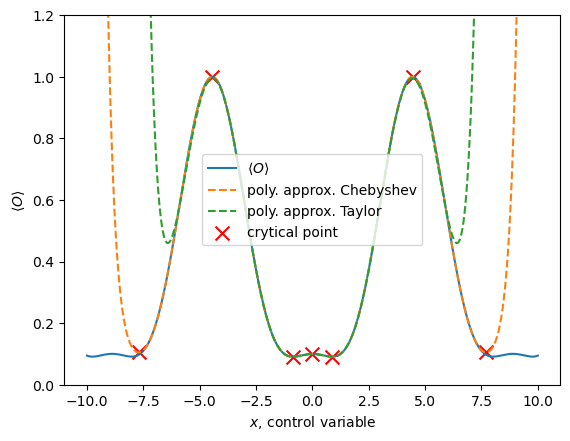

In [11]:
plot(ξ, average_O, label=L"\langle O \rangle")
plot(ξ, obj_chebyshev.(ξ), "--", label="poly. approx. Chebyshev")
plot(ξ, obj_taylor.(ξ), "--", label="poly. approx. Taylor")

scatter(critical_points_chebyshev, obj_chebyshev.(critical_points_chebyshev), 100, marker="x", color="r", label="crytical point")
ylim(0, 1.2)

xlabel(L"x" * ", control variable")
ylabel(L"\langle O \rangle")
legend()

savefig("Fig_OwithTrap.pdf")

show()